# Bag of Words for Disaster Tweets
## Let's Clean it up!

Used to gather words in to common groups and allows one to extract all the non-words and stop words, etc.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# import the training dataset for examination
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print(train.shape, test.shape)
print(train.head(8))

(7613, 5) (3263, 4)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
5   8     NaN      NaN  #RockyFire Update => California Hwy. 20 closed...   
6  10     NaN      NaN  #flood #disaster Heavy rain causes flash flood...   
7  13     NaN      NaN  I'm on top of the hill and I can see a fire in...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  



Bad key text.latex.preview in file C:\Users\bkuro\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\bkuro\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\bkuro\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

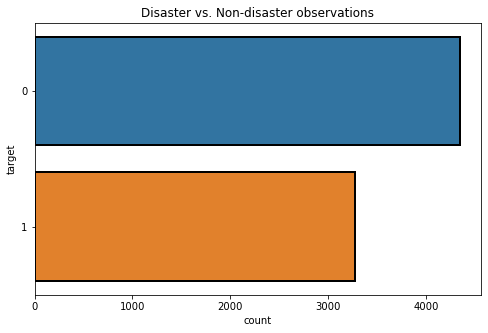

Non-disaster : 4342
Disaster : 3271


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
# Observe the ratio of disaster vs. non-disaster information
plt.figure(figsize=(8,5))
plt.title("Disaster vs. Non-disaster observations")
sns.countplot(y=train["target"],linewidth=2,
                   edgecolor='black')

plt.show()
print("Non-disaster :", train["target"][train["target"]==0].count())
print("Disaster :", train["target"][train["target"]==1].count())


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


In [6]:
train_bag = count.fit_transform(train['text'])
test_bag = count.fit_transform(test['text'])
# They are now sparse feature vectors - huzzah!

NameError: name 'count' is not defined

In [7]:
# Observe the contents of the transformed features (unigram):
print(count.vocabulary_)
print(train_bag.toarray())

NameError: name 'count' is not defined

### Data should be preprocessed - especially for 'dirt' in text info

In [8]:
import re
import emoji  #Modern removal regex emojis (or addition thereof, si vous voulez)
# The stop words will not give much feedback to the algorithms being run
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Simple but largely effective for a first/fast-approach
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bkuro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sub-functions to cleans the information found in Tweets before true use in models and visualizations

In [9]:

thestopwords = stopwords.words('english') + ['im', 'dont', 'doin', 'ure', 'u','cya', 'via', 'lol', 'ü', 'ur', '4', '2']
# Group the redundant words
def stemmer(text):
    return [porter.stem(word) for word in text if word not in thestopwords]

# Remove any of the modern emojis present
def remove_emoji(text):
    return emoji.demojize(text)
def preprocessor(text):
    # Get rid of most of the HTML markups contained
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text)
    # Hunt for the simple emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    # Lose the non-word characters (presuming names aren't a big feature in this case)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    # Tough to work with newer emojis here
    text = remove_emoji(text)
    # Misc encounters
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.lower()
    # ---------------------------- Cutting & pasting actions
    text = text.split()
    text = stemmer(text)
    # Drop the tiny words as well
    text = [w for w in text if len(w)>2]
    text = ' '.join(text)
    
    return text
    

In [10]:
train['clean_text'] = train['text'].apply(preprocessor)
test['clean_text'] = test['text'].apply(preprocessor)

In [11]:
print(train['clean_text'])

0                  deed reason earthquak may allah forgiv
1                       forest fire near rong sask canada
2       resid ask shelter place notifi offic evacu she...
3             peopl receiv wildfir evacu order california
4       got sent photo rubi alaska smoke wildfir pour ...
                              ...                        
7608       two giant crane hold bridg collaps nearbi home
7609    aria ahrari thetawniest control wild fire cali...
7610                                   utc volcano hawaii
7611    polic investig bike collid car littl portug bi...
7612    latest home raze northern california wildfir a...
Name: clean_text, Length: 7613, dtype: object


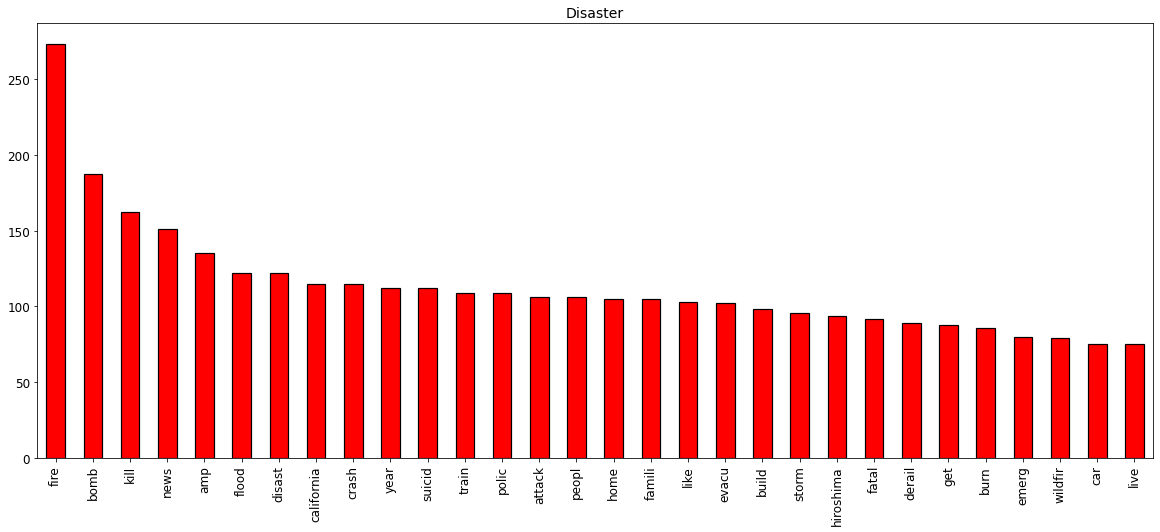

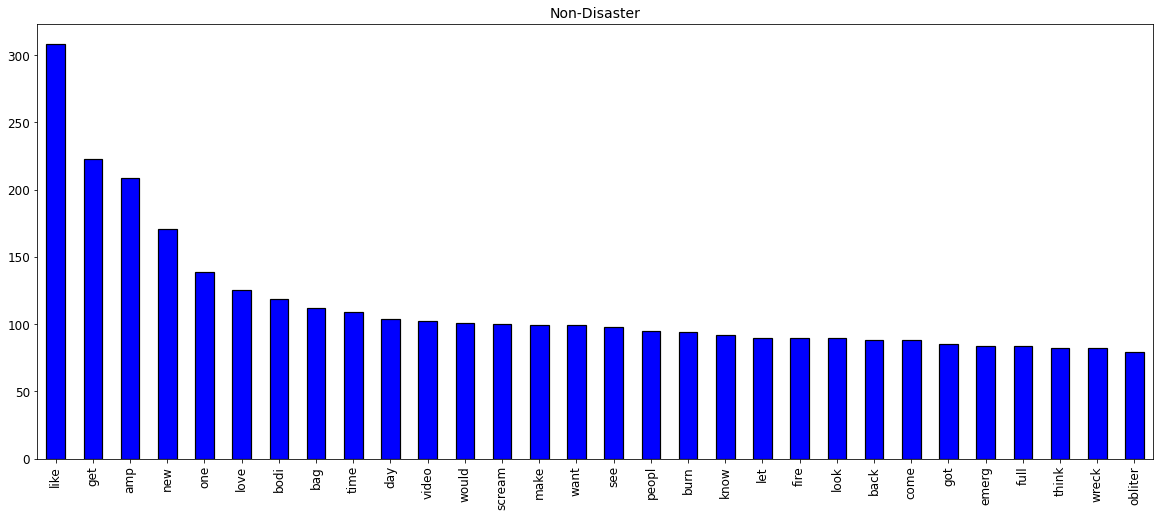

In [12]:
# Investigate the top words in each set

disaster = train[train.target==1]["clean_text"]
non_disaster = train[train.target==0]["clean_text"]

color = ['autumn','winter']
split_sets = [disaster,non_disaster]
header = ["Disaster", "Non-Disaster"]
for item in range(2):
    plt.figure(figsize=(20,8))
    plt.title(header[item],fontsize=14)
    pd.Series(' '.join([i for i in split_sets[item]]).split()).value_counts().head(30).plot(kind='bar',fontsize=12,colormap=color[item],edgecolor='black', linewidth=1.2)
    plt.show()

In [13]:
# Junk text (mostly 3-letter items):
junk = ['like', 'get', 'amp', 'one', 'two', 'three', 'via', 'build','see','say','may','way','let', 'come', 'lol',
        'got', 'make', 'want','back','come','think','day','would']
def no_junk(text):
    return ' '.join(w for w in text.split() if w not in junk)

In [14]:
train["clean_text"] = train["clean_text"].apply(no_junk)
test["clean_text"] = test["clean_text"].apply(no_junk)

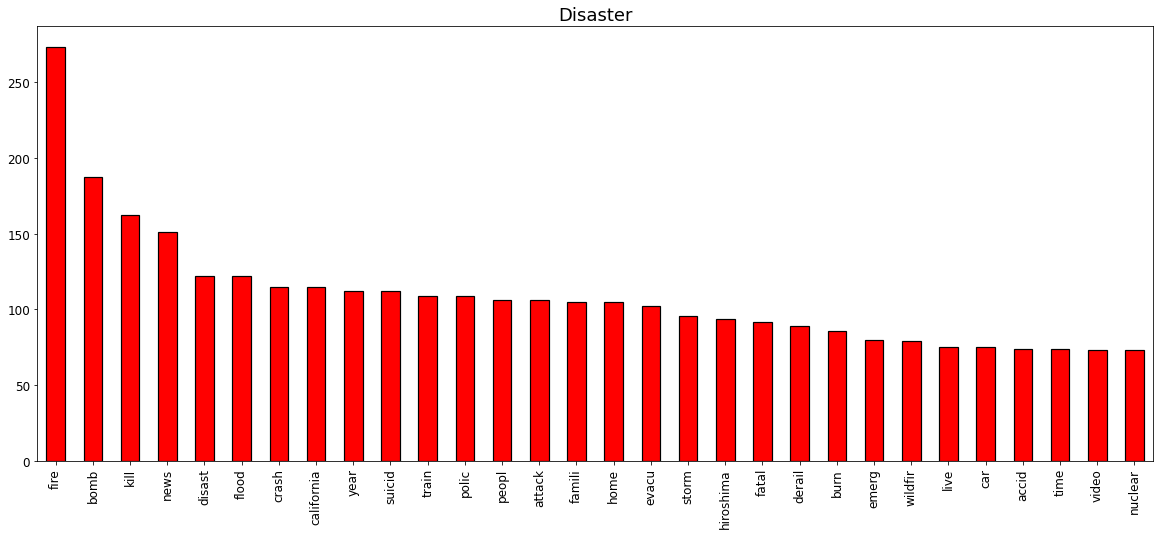

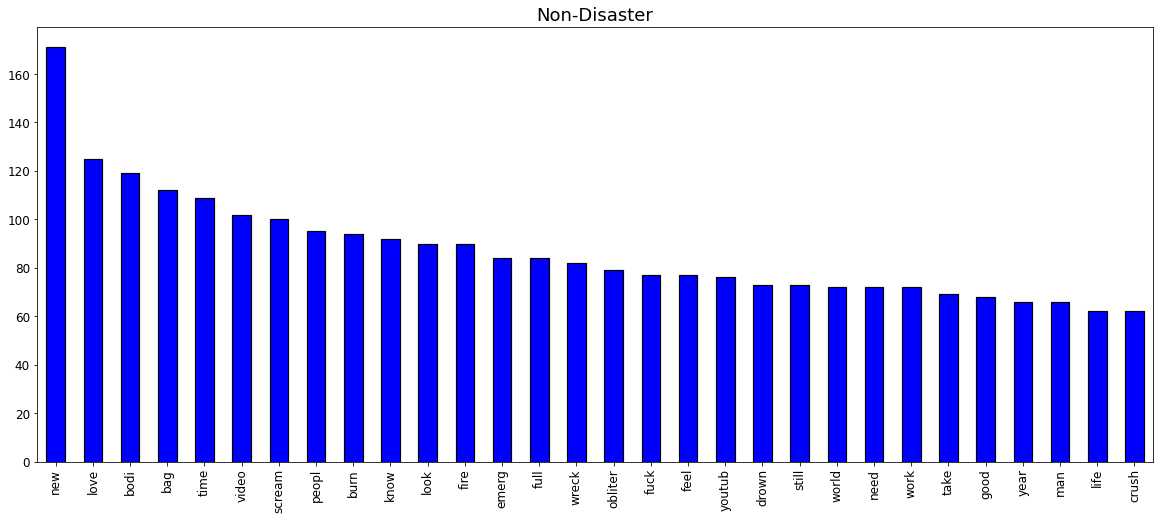

In [15]:
# Re-investigate the top CLEAN words in each set

disaster = train[train.target==1]["clean_text"]
non_disaster = train[train.target==0]["clean_text"]

color = ['autumn','winter']
split_sets = [disaster,non_disaster]
header = ["Disaster", "Non-Disaster"]
for item in range(2):
    plt.figure(figsize=(20,8))
    plt.title(header[item],fontsize=18)
    pd.Series(' '.join([i for i in split_sets[item]]).split()).value_counts().head(30).plot(kind='bar',fontsize=12,colormap=color[item],edgecolor='black', linewidth=1.2)
    plt.show()

In [16]:
# I have to say that I'm surprised 'fuck' ONLY shows up in non-disaster, I honestly assumed the opposite.

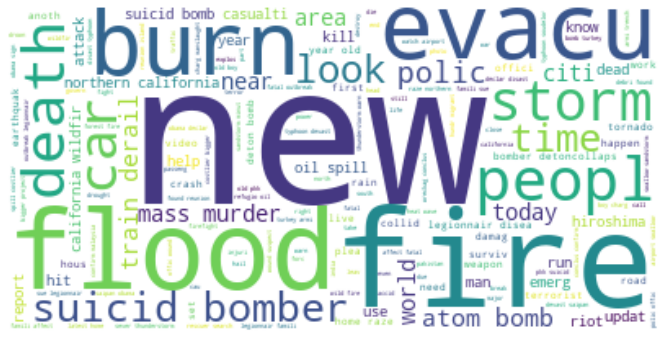

In [17]:
# Check the disaster word cloud for understanding
from wordcloud import WordCloud
plt.figure(figsize=(12,6))

wc = WordCloud(background_color='white')
wc.generate(' '.join(train['clean_text'][train['target']==1]))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## Bag Of Words using the top Ngrams:

In [18]:
# Creating function for analysing top n-grams

def top_ngrams(df,n,grams):

    if grams == 1:  # Do mono...
        model = CountVectorizer(ngram_range=(1,1)).fit(df)
        bag_of_words = model.transform(df)
        sum_words = bag_of_words.sum(axis=0)
        word_freq = [(word, sum_words[0, idx]) for word, idx in model.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 2: # ... Dual
        model = CountVectorizer(ngram_range=(2,2)).fit(df)
        bag_of_words = model.transform(df)
        sum_words = bag_of_words.sum(axis=0)
        word_freq = [(word,sum_words[0,idx]) for word,idx in model.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 3: # ... and tripple
        model = CountVectorizer(ngram_range=(3,3)).fit(df)
        bag_of_words = model.transform(df)
        sum_words = bag_of_words.sum(axis=0)
        word_freq = [(word,sum_words[0,idx]) for word,idx in model.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)

    return word_freq[:n]

C:\Users\bkuro\AppData\Local\Temp\ipykernel_23520\3306228206.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rotation=-45,labels=unigram_df["word"],fontsize=12)
C:\Users\bkuro\AppData\Local\Temp\ipykernel_23520\3306228206.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(rotation=-45,labels=bigram_df["word"],fontsize=12)
C:\Users\bkuro\AppData\Local\Temp\ipykernel_23520\3306228206.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(rotation=-45,labels=trigram_df["word"],fontsize=12)


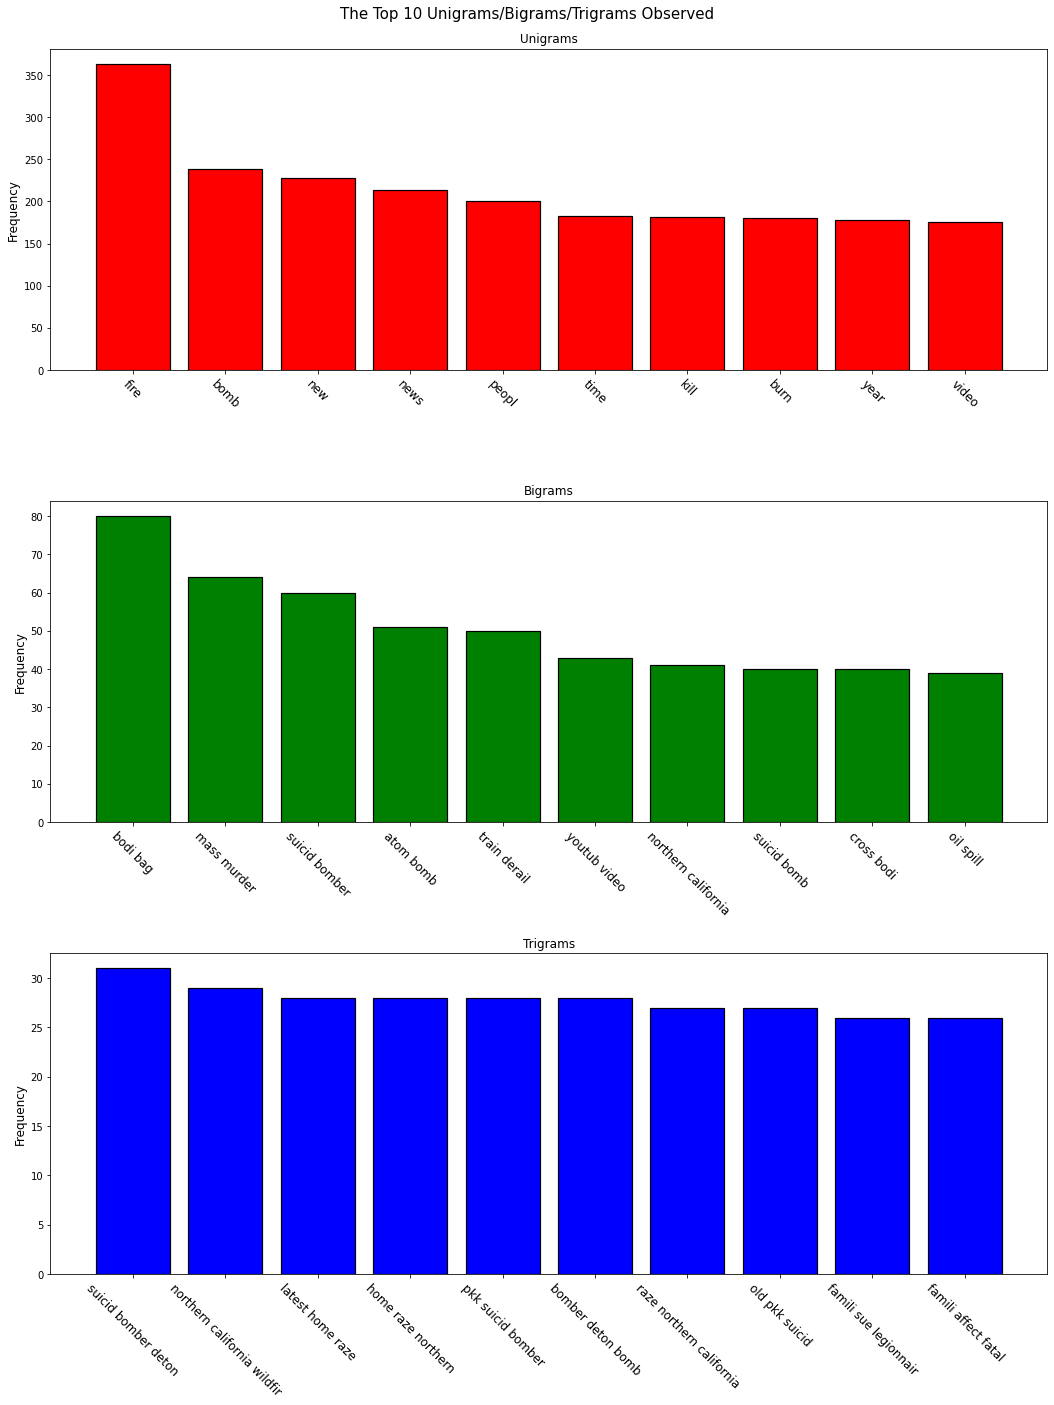

In [19]:
# The common words observations
words_uni = top_ngrams(train["clean_text"],10,1)
words_bi = top_ngrams(train["clean_text"],10,2)
words_tri = top_ngrams(train["clean_text"],10,3)
unigram_df = pd.DataFrame(words_uni,columns=['word','freq'])
bigram_df = pd.DataFrame(words_bi,columns=['word','freq'])
trigram_df = pd.DataFrame(words_tri,columns=['word','freq'])

# Set up a plot for visualization
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))
ax1.bar(unigram_df["word"],unigram_df["freq"],color="red",edgecolor='black', linewidth=1.2)
ax1.set_title("Unigrams")
ax1.set_ylabel("Frequency",fontsize=12)
ax1.set_xticklabels(rotation=-45,labels=unigram_df["word"],fontsize=12)    

ax2.bar(bigram_df["word"],bigram_df["freq"],color="green",edgecolor='black', linewidth=1.2)
ax2.set_title("Bigrams")
ax2.set_ylabel("Frequency",fontsize=12)
ax2.set_xticklabels(rotation=-45,labels=bigram_df["word"],fontsize=12)    

ax3.bar(trigram_df["word"],trigram_df["freq"] ,color="blue",edgecolor='black', linewidth=1.2)
ax3.set_title("Trigrams")
ax3.set_ylabel("Frequency",fontsize=12)
ax3.set_xticklabels(rotation=-45,labels=trigram_df["word"],fontsize=12) 
plt.suptitle("The Top 10 Unigrams/Bigrams/Trigrams Observed",fontsize="15")
plt.tight_layout(pad=2)
plt.show()


### Bag of Words can now be used for applications:

In [20]:
# Model can now move from BoW to TF-IDF

X = train.drop(columns=["target"],axis=1)
y = train["target"]

def encoding(training,testing):

    model = CountVectorizer(ngram_range=(1, 1))  # 1-D for now
    traing_model = model.fit_transform(training).toarray()
    training_df = pd.DataFrame(traing_model,columns=model.get_feature_names())
    testing_model = model.transform(testing).toarray()
    testing_df = pd.DataFrame(testing_model,columns=model.get_feature_names())

    return training_df,testing_df


x_train_final,x_test_final = encoding(train["clean_text"],test["clean_text"])
y_final = np.array(y)

C:\Users\bkuro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\bkuro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
# Checking dimensions of training and testing data
x_train_final.shape,y_final.shape,x_test_final.shape

((7613, 12691), (7613,), (3263, 12691))

In [22]:
# Do a train-test split of the dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train_final, y_final, test_size=0.15, random_state=25, stratify = y_final)


In [23]:
# Go with a random forest to observe
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score

model_bow = RandomForestClassifier()
model_bow.fit(x_train,y_train)
pred_bow = model_bow.predict(x_test)
cr_bow    = classification_report(y_test,pred_bow)
print(cr_bow)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       651
           1       0.84      0.66      0.74       491

    accuracy                           0.80      1142
   macro avg       0.81      0.78      0.79      1142
weighted avg       0.81      0.80      0.80      1142



##  Moving towards traditional ML Models

In [24]:
# Flip over to TF_IDF
from sklearn.feature_extraction.text import TfidfVectorizer

def encoding(training,testing):
    tfidf = TfidfVectorizer(ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1)    
    tf_training = tfidf.fit_transform(training).toarray()
    training_df = pd.DataFrame(tf_training,columns=tfidf.get_feature_names())
    tf_testing = tfidf.transform(testing).toarray()
    testing_df = pd.DataFrame(tf_testing,columns=tfidf.get_feature_names())

    return training_df,testing_df

x_train_final,x_test_final = encoding(train["clean_text"],test["clean_text"])
y_final = np.array(y)

C:\Users\bkuro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\bkuro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# Lets see what happens with a random forest again
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score

x_train, x_valid, y_train, y_valid = train_test_split(x_train_final, y_final, test_size=0.15, random_state=19, stratify = y_final)

model_idf = RandomForestClassifier()
model_idf.fit(x_train,y_train)
pred_idf = model_idf.predict(x_test)
cr_idf    = classification_report(y_test,pred_idf)
print(cr_idf)

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       651
           1       0.86      0.93      0.90       491

    accuracy                           0.91      1142
   macro avg       0.91      0.91      0.91      1142
weighted avg       0.91      0.91      0.91      1142



94 and 87?  I like that alot more!

## Move to word embeddings with a linear classifier

(glove it is then)

In [26]:
# Drop many different imports in attempt to get access to generic_utils before six.
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K

C:\Users\bkuro\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bkuro\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bkuro\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bkuro\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

ImportError: cannot import name 'transpose_shape' from 'keras.utils.generic_utils' (C:\Users\bkuro\Anaconda3\lib\site-packages\keras\utils\generic_utils.py)

In [27]:
# Given the time limit this Saturday, debugging the library error will not be achievalbe unfortunately!

In [28]:
# It should understand if it is in a list format
train_text = train["clean_text"].tolist()
test_text = test["clean_text"].tolist()

In [29]:
# Each word now needs its own token to be properly processed and intrepreted
my_token = Tokenizer()
my_token.fit_on_texts(train_text)

NameError: name 'Tokenizer' is not defined

In [30]:
# The tokens will display words in numerical format here:
encoded_text = my_token.texts_to_sequences(train_text)
encoded_text_test = my_token.texts_to_sequences(test_text)


NameError: name 'my_token' is not defined

In [ ]:
#Splitting into training-test data for vectorized tokens
# X is up by "Bag of Words"
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=15, stratify = y_train)


In [ ]:
# A proposed linear model to handle tokenized information
from sklearn.linear_model import SGDClassifier
lin_model = SGDClassifier()
lin_model.fit(X_train,Y_train)
lin_pred = lin_model.predict(x_test)
cr_lin = classification_report(y_test,lin_pred)
print(cr_lin)

## Conclusions

The observable results thus far before Glove embeddings:

In [31]:
print(cr_bow)
print(cr_idf)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       651
           1       0.84      0.66      0.74       491

    accuracy                           0.80      1142
   macro avg       0.81      0.78      0.79      1142
weighted avg       0.81      0.80      0.80      1142

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       651
           1       0.86      0.93      0.90       491

    accuracy                           0.91      1142
   macro avg       0.91      0.91      0.91      1142
weighted avg       0.91      0.91      0.91      1142



It can be seen that the more active IDF-style can make a more reliable model where a Random Forest is first attempted due to reliability and in this particular study-case consistency.  Unfortunately, due to a Keras conflict with a past version of Python 3 on Jupyter, further analysis on the vectorized Glove-style cannot be concluded immediately.

Precision has improved overall by about 10%  and has become far more reliable concerning those Tweets that are casual in nature and unrelated to disaster-recognition.

As a proposal, Random Forest is a reliable model that avoids the monotomy and bias that may exist with common decision trees.  The interpretability is still reasonably engaged with it but should often be more reliable than naive Bayes or an UNTUNED (as discussed before) log regression which is "hit or miss" in my experience.

We would have found a "very" large draw on time and computer resources with the Glove steps including addition of word vectors AND matrix representation before even engaging the model.  Assuming the learning rate is not refined (say around 0.25 for speed), it could flatten out after 20 cycles and progress slowly.  It's a balancing act!